# FACE Basic Results

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../..'))

%load_ext autoreload
%autoreload 2

import numba
import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn import model_selection

import matplotlib.pyplot as plt
import seaborn as sns
from models import model_interface, model_loader, model_constants
from data import data_loader
from data.adapters import continuous_adapter

# Preliminaries -- load everything

In [3]:
DATASET, VAL_DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName('credit_card_default'), split=["train", "val"])
MODEL = model_loader.load_model(model_constants.ModelType('logistic_regression'), data_loader.DatasetName('credit_card_default'))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)

DROP_COLUMNS = ['step_id', 'path_id', 'run_id', 'batch_id']

results_dir = '../../experiment_results/face/face_hyperparam'

index_df = pd.read_csv(os.path.join(results_dir, 'experiment_config_df.csv'))
path_df = pd.read_csv(os.path.join(results_dir, 'face_paths_df.csv'))
index_df

,batch_id,run_id,run_seed,confidence_cutoff,counterfactual_mode,dataset_name,distance_threshold,graph_directory,max_iterations,model_type,noise_ratio,num_paths,rescale_ratio,split,elapsed_recourse_seconds
0,29,894,3069,0.7,True,credit_card_default,1.00,recourse_methods/face_graphs,50,logistic_regression,NaN,5,NaN,val,0.828081
1,59,1780,3363,0.8,True,credit_card_default,2.50,recourse_methods/face_graphs,50,logistic_regression,NaN,5,NaN,val,2.156598
2,18,568,6779,0.6,True,credit_card_default,2.50,recourse_methods/face_graphs,50,logistic_regression,NaN,4,NaN,val,3.332527
3,66,1982,1701,0.9,True,credit_card_default,1.00,recourse_methods/face_graphs,50,logistic_regression,NaN,2,NaN,val,0.395447
4,11,345,3439,0.6,True,credit_card_default,1.50,recourse_methods/face_graphs,50,logistic_regression,NaN,2,NaN,val,1.262999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,6,203,211,0.6,True,credit_card_default,1.00,recourse_methods/face_graphs,50,logistic_regression,NaN,2,NaN,val,0.309175
2396,48,1458,2020,0.8,True,credit_card_default,1.00,recourse_methods/face_graphs,50,logistic_regression,NaN,4,NaN,val,0.300586
2397,31,954,3069,0.7,True,credit_card_default,1.50,recourse_methods/face_graphs,50,logistic_regression,NaN,2,NaN,val,0.663127
2398,24,735,3439,0.7,True,credit_card_default,0.75,recourse_methods/face_graphs,50,logistic_regression,NaN,5,NaN,val,0.215227


## Fit a KDE

In [4]:
kfold = model_selection.KFold(n_splits=5)
transformed_data = ADAPTER.transform(DATASET.drop(columns='Y')).sample(frac=1, replace=False)

bandwidths = np.logspace(-1, 0, 6)
scores = []

for bw in bandwidths:
    print("Evaluate bandwidth", bw)
    score = 0
    for train_indices, val_indices in kfold.split(transformed_data):
        kde = neighbors.KernelDensity(bandwidth=bw).fit(transformed_data.iloc[train_indices])
        score += kde.score(transformed_data.iloc[val_indices])
    scores.append(score / len(bandwidths))
    print(scores[-1])
best_bandwidth = bandwidths[np.argmax(scores)]
print("Finished! Selected bandwidth is ", best_bandwidth)
KDE = neighbors.KernelDensity(bandwidth=bw).fit(transformed_data)
print("Scoring full dataset...")
scores = KDE.score_samples(transformed_data)

Evaluate bandwidth 0.1
-192656.45446479597
Evaluate bandwidth 0.15848931924611134
-70892.6080646542
Evaluate bandwidth 0.251188643150958
-37409.074414008566
Evaluate bandwidth 0.3981071705534973
-41513.62730752238
Evaluate bandwidth 0.6309573444801934
-58689.16829151127
Evaluate bandwidth 1.0
-81925.2791079895
Finished! Selected bandwidth is  0.251188643150958
Scoring full dataset...


### Evaluate the KDE qualitatively

The scores are between -28 and -20. Unsurprisingly, most points have relatively high density.
Overall the histogram seems reasonable.

In [4]:
# best_bandwidth = bandwidths[np.argmax(scores)]
transformed_data = ADAPTER.transform(DATASET.drop(columns='Y')).sample(frac=1, replace=False)
best_bandwidth = 0.251188643150958
KDE = neighbors.KernelDensity(bandwidth=best_bandwidth).fit(transformed_data)
if False:
    KDE_SCORES = KDE.score_samples(transformed_data)
    sns.histplot(KDE_SCORES)
    pd.DataFrame({'density': KDE_SCORES}).describe()

# Analyze the results

In [11]:
SPARSITY_EPSILON = 1e-9

def get_sparsity2(path: pd.DataFrame):
    if path.shape[0] == 1:
        return np.nan
    path_sparsity = np.zeros(path.shape[0])
    for i in range(1, path.shape[0]):
        path_sparsity[i] = (np.abs(path.iloc[i] - path.iloc[i - 1]) > SPARSITY_EPSILON).sum()
    return np.max(path_sparsity)

def get_path_length2(path: pd.DataFrame):
    total = 0
    for i in range(1, path.shape[0]):
        total += np.linalg.norm(path.iloc[i] - path.iloc[i - 1])
    if total == 0:
        return np.nan
    return total

def get_cfe_distance2(path: pd.DataFrame):
    if len(path) == 1:
        return np.nan
    return np.linalg.norm(path.iloc[-1] - path.iloc[0])

def get_poi_cfes(path_df):
    pathscopy = path_df.copy()
    pathscopy['next_step_id'] = 0
    pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]
    cfes = pathscopy[pathscopy.step_id >= pathscopy.next_step_id].drop(columns='next_step_id')
    return pathscopy[pathscopy.step_id == 0].drop(columns='next_step_id'), cfes
    
pois, cfes = get_poi_cfes(path_df)

/tmp/ipykernel_17012/3388884781.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]


In [16]:
poi_kdes = KDE.score_samples(ADAPTER.transform(pois.drop(columns=DROP_COLUMNS)))
cfe_kdes = KDE.score_samples(ADAPTER.transform(cfes.drop(columns=DROP_COLUMNS)))
cfe_probs = MODEL.predict_pos_proba(cfes.drop(columns=DROP_COLUMNS)).to_numpy()

In [18]:
def analyze_paths2(paths: pd.DataFrame, poi_kdes, cfe_kdes, cfe_probs, config_df):
    columns = ['run_id', 'path_id', 'success', 'proximity', 'path_length', 'iteration_count', 'poi_density', 'cfe_density', 'actual_sparsity']
    col_idx = {}
    for i, col in enumerate(columns):
        col_idx[col] = i

    results = np.zeros((len(poi_kdes), len(columns)))

    i = 0
    for run_id in paths.run_id.unique():
        run_paths = paths[paths.run_id == run_id]
        for path_id in run_paths.path_id.unique():
            path = ADAPTER.transform(run_paths[run_paths.path_id == path_id].drop(columns=DROP_COLUMNS))
            results[i,col_idx['run_id']] = run_id
            results[i,col_idx['path_id']] = path_id

            desired_proba = config_df[config_df.run_id == run_id].confidence_cutoff.iloc[0]
            actual_proba = cfe_probs[i]

            results[i,col_idx['success']] = 1 if actual_proba >= desired_proba else 0
            results[i,col_idx['path_length']] = get_path_length2(path)
            results[i,col_idx['iteration_count']] = len(path)
            results[i,col_idx['proximity']] = get_cfe_distance2(path)
            results[i,col_idx['poi_density']] = poi_kdes[i]
            results[i,col_idx['cfe_density']] = cfe_kdes[i]
            results[i,col_idx['actual_sparsity']] = get_sparsity2(path)
            i += 1

    return pd.DataFrame(data=results, columns=columns)

results = analyze_paths2(path_df, poi_kdes, cfe_kdes, cfe_probs, index_df)
results = results.merge(index_df, how='left', on='run_id').drop(columns=['dataset_name', 'max_iterations', 'model_type', 'noise_ratio', 'rescale_ratio', 'run_seed', 'split'])

In [19]:
results

,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,counterfactual_mode,distance_threshold,graph_directory,num_paths,elapsed_recourse_seconds
0,894.0,0.0,0.0,NaN,NaN,1.0,-69.439821,-69.439821,NaN,29,0.7,True,1.00,recourse_methods/face_graphs,5,0.828081
1,894.0,1.0,0.0,NaN,NaN,1.0,-69.439821,-69.439821,NaN,29,0.7,True,1.00,recourse_methods/face_graphs,5,0.828081
2,894.0,2.0,0.0,NaN,NaN,1.0,-69.439821,-69.439821,NaN,29,0.7,True,1.00,recourse_methods/face_graphs,5,0.828081
3,894.0,3.0,0.0,NaN,NaN,1.0,-69.439821,-69.439821,NaN,29,0.7,True,1.00,recourse_methods/face_graphs,5,0.828081
4,894.0,4.0,0.0,NaN,NaN,1.0,-69.439821,-69.439821,NaN,29,0.7,True,1.00,recourse_methods/face_graphs,5,0.828081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,735.0,2.0,0.0,NaN,NaN,1.0,1.339605,1.339605,NaN,24,0.7,True,0.75,recourse_methods/face_graphs,5,0.215227
7196,735.0,3.0,0.0,NaN,NaN,1.0,1.339605,1.339605,NaN,24,0.7,True,0.75,recourse_methods/face_graphs,5,0.215227
7197,735.0,4.0,0.0,NaN,NaN,1.0,1.339605,1.339605,NaN,24,0.7,True,0.75,recourse_methods/face_graphs,5,0.215227
7198,1995.0,0.0,0.0,NaN,NaN,1.0,1.339605,1.339605,NaN,66,0.9,True,1.00,recourse_methods/face_graphs,2,0.299082


# Let's look at the average metrics across the full batch

* StEP never fails
* As we add more clusters, the path_length and proximity increases. This is not surprising since it just an average and we will add some distant clusters

In [22]:
results['negative_cfe_density'] = -results['cfe_density']
results['negative_success'] = -results['success']
results.groupby('batch_id').mean().sort_values(['negative_success', 'path_length', 'proximity', 'negative_cfe_density', 'iteration_count'])

/tmp/ipykernel_17012/996993128.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results.groupby('batch_id').mean().sort_values(['negative_success', 'path_length', 'proximity', 'negative_cfe_density', 'iteration_count'])


,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,confidence_cutoff,counterfactual_mode,distance_threshold,num_paths,elapsed_recourse_seconds,negative_cfe_density,negative_success
batch_id,,,,,,,,,,,,,,,,
15,464.5,0.0,0.700000,3.541706,3.541706,1.700000,-7.00341,-3.485908,14.761905,0.6,1.0,2.5,1.0,2.717159,3.485908,-0.700000
16,494.5,0.5,0.700000,3.650092,3.650092,1.700000,-7.00341,-3.453847,14.404762,0.6,1.0,2.5,2.0,2.777314,3.453847,-0.700000
17,524.5,1.0,0.688889,3.646413,3.646413,1.688889,-7.00341,-3.472515,14.419355,0.6,1.0,2.5,3.0,2.898568,3.472515,-0.688889
18,554.5,1.5,0.683333,3.656454,3.656454,1.683333,-7.00341,-3.437925,14.585366,0.6,1.0,2.5,4.0,3.034013,3.437925,-0.683333
19,584.5,2.0,0.680000,3.691335,3.691335,1.680000,-7.00341,-3.447518,14.558824,0.6,1.0,2.5,5.0,2.993000,3.447518,-0.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,1994.5,0.5,0.000000,NaN,NaN,1.000000,-7.00341,-7.003410,NaN,0.9,1.0,1.0,2.0,0.380030,7.003410,0.000000
67,2024.5,1.0,0.000000,NaN,NaN,1.000000,-7.00341,-7.003410,NaN,0.9,1.0,1.0,3.0,0.384897,7.003410,0.000000
68,2054.5,1.5,0.000000,NaN,NaN,1.000000,-7.00341,-7.003410,NaN,0.9,1.0,1.0,4.0,0.413788,7.003410,0.000000


In [23]:
results.groupby('distance_threshold').mean()

/tmp/ipykernel_17012/2106696733.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results.groupby('distance_threshold').mean()


,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,counterfactual_mode,num_paths,elapsed_recourse_seconds,negative_cfe_density,negative_success
distance_threshold,,,,,,,,,,,,,,,,
0.75,994.5,1.333333,0.000000,NaN,NaN,1.000000,-7.00341,-7.003410,NaN,32.666667,0.75,1.0,3.666667,0.306906,7.003410,0.000000
1.00,1144.5,1.333333,0.016667,3.949296,3.949296,1.016667,-7.00341,-7.045234,14.000000,37.666667,0.75,1.0,3.666667,0.413500,7.045234,-0.016667
1.50,1294.5,1.333333,0.405000,3.840691,3.840691,1.405000,-7.00341,-5.908758,14.510288,42.666667,0.75,1.0,3.666667,1.126514,5.908758,-0.405000
2.50,1444.5,1.333333,0.568333,4.639235,4.639235,1.568333,-7.00341,-4.728617,14.967742,47.666667,0.75,1.0,3.666667,2.888642,4.728617,-0.568333


In [24]:
results[results.distance_threshold == 2.5].groupby('confidence_cutoff').mean()

/tmp/ipykernel_17012/2365701266.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results[results.distance_threshold == 2.5].groupby('confidence_cutoff').mean()


,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,counterfactual_mode,distance_threshold,num_paths,elapsed_recourse_seconds,negative_cfe_density,negative_success
confidence_cutoff,,,,,,,,,,,,,,,,
0.6,544.5,1.333333,0.686667,3.657290,3.657290,1.686667,-7.00341,-3.453362,14.530744,17.666667,1.0,2.5,3.666667,2.937903,3.453362,-0.686667
0.7,1144.5,1.333333,0.586667,4.061018,4.061018,1.586667,-7.00341,-4.504095,15.125000,37.666667,1.0,2.5,3.666667,2.925453,4.504095,-0.586667
0.8,1744.5,1.333333,0.500000,4.653009,4.653009,1.500000,-7.00341,-5.474701,15.111111,57.666667,1.0,2.5,3.666667,2.853580,5.474701,-0.500000
0.9,2344.5,1.333333,0.500000,6.652441,6.652441,1.500000,-7.00341,-5.482309,15.240000,77.666667,1.0,2.5,3.666667,2.837631,5.482309,-0.500000


# Choosing Parameters:

Paramset 1:  we want proximal points, iteration count doesn't matter
* 3 clusters <- chosen to match StEP
* confidence 0.6 <- chosent to match StEP


Paramset 2:  we want high-confidence points with low iteration count
* 3 clusters <- chosen to match StEP
* confidence 0.8 <- chosen to match StEP


DiCE is not sensitive to num_paths or confidence_cutoff

In [50]:
results.groupby('num_paths').mean()

,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,elapsed_recourse_seconds,negative_cfe_density
num_paths,,,,,,,,,,,,,
1,239.5,0.0,1.0,38.488328,38.488328,2.0,-7.003428,-3463.172114,1.675000,7.5,0.75,1.041397,3463.172114
2,269.5,0.5,1.0,38.045591,38.045591,2.0,-7.003428,-3515.990727,1.637500,8.5,0.75,1.718656,3515.990727
3,299.5,1.0,1.0,38.118294,38.118294,2.0,-7.003428,-3584.048006,1.638889,9.5,0.75,3.167917,3584.048006
4,329.5,1.5,1.0,38.402391,38.402391,2.0,-7.003428,-3693.762086,1.645833,10.5,0.75,5.001183,3693.762086
5,359.5,2.0,1.0,38.696772,38.696772,2.0,-7.003428,-3786.542834,1.651667,11.5,0.75,5.430140,3786.542834


In [51]:
results.groupby('confidence_cutoff').mean()

,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,num_paths,elapsed_recourse_seconds,negative_cfe_density
confidence_cutoff,,,,,,,,,,,,,
0.6,94.5,1.333333,1.0,37.005525,37.005525,2.0,-7.003428,-3890.401547,1.626667,2.666667,3.666667,1.431268,3890.401547
0.7,244.5,1.333333,1.0,36.412764,36.412764,2.0,-7.003428,-3234.428580,1.680000,7.666667,3.666667,3.382224,3234.428580
0.8,394.5,1.333333,1.0,38.840406,38.840406,2.0,-7.003428,-3441.413933,1.617778,12.666667,3.666667,9.456369,3441.413933
0.9,544.5,1.333333,1.0,41.348722,41.348722,2.0,-7.003428,-4088.438633,1.664444,17.666667,3.666667,2.033577,4088.438633


# Choosing parameters:

* As you require higher confidence,
  - CFE density is lower
  - proximity is higher
  - path length is higher
  - iteration count increases

* As you request more clusters,
  - proximity and path length are slightly increased
  - density is higher
  - iteration count slightly increases

* As you give larger step sizes,
  - same observations as before, but it's not drastic
  - iteration count decreases


Paramset 1:  we want proximal points, iteration count doesn't matter
* 3 clusters <- chosen for convenience
* confidence 0.6 <- this is the best-ranked
* 0.5 step size <- this is the best-ranked


Paramset 2:  we want high-confidence points with low iteration count
* 3 clusters
* confidence 0.8
* 4 step size <- this is best-ranked for low iteration count

In [52]:
results['density_difference'] = results['poi_density'] - results['cfe_density']

<AxesSubplot: xlabel='density_difference', ylabel='Count'>

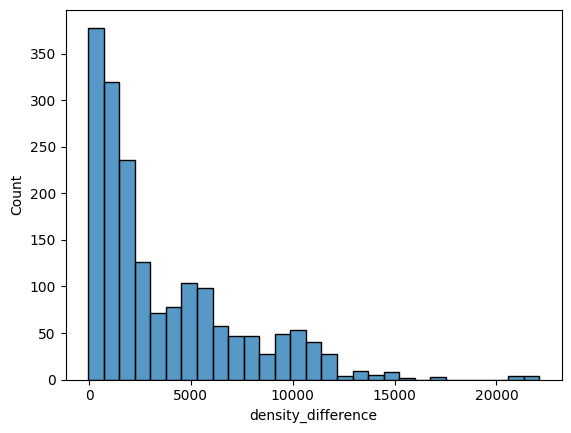

In [54]:
sns.histplot(results, x='density_difference')

In [151]:
avg_results = results.groupby('batch_id').mean()

In [153]:
avg_results[avg_results.density_difference <= 0]

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,confidence_cutoff,num_clusters,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds,negative_cfe_density,density_difference
batch_id,,,,,,,,,,,,,,,
0,14.5,0.0,1.0,4.682907,4.700000,-6.874009,0.001315,20.0,0.6,1.0,0.5,1.869200,0.239150,-0.001315,-6.875323
1,44.5,0.0,1.0,4.946972,4.966667,-6.874009,0.705603,20.0,0.6,1.0,1.0,0.946551,0.206301,-0.705603,-7.579612
2,74.5,0.0,1.0,5.440978,5.466667,-6.874009,-0.827490,20.0,0.6,1.0,2.0,0.516620,0.198520,0.827490,-6.046519
4,134.5,0.5,1.0,5.306274,5.316667,-6.874009,-1.707263,20.0,0.6,2.0,0.5,3.813711,0.327369,1.707263,-5.166745
5,164.5,0.5,1.0,5.522126,5.533333,-6.874009,-1.147836,20.0,0.6,2.0,1.0,1.960824,0.283712,1.147836,-5.726173
6,194.5,0.5,1.0,6.019660,6.033333,-6.874009,-1.606514,20.0,0.6,2.0,2.0,1.053803,0.344702,1.606514,-5.267494
20,614.5,0.0,1.0,5.322702,5.383333,-6.874009,-1.270549,20.0,0.7,1.0,0.5,1.919914,0.178869,1.270549,-5.603460
21,644.5,0.0,1.0,5.525584,5.600000,-6.874009,-1.322610,20.0,0.7,1.0,1.0,1.115797,0.196995,1.322610,-5.551399
22,674.5,0.0,1.0,5.916247,6.000000,-6.874009,-3.678051,20.0,0.7,1.0,2.0,0.539779,0.189563,3.678051,-3.195957


In [155]:
avg_results[(avg_results.density_difference > 0) & (avg_results.density_difference <= 10)]

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,confidence_cutoff,num_clusters,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds,negative_cfe_density,density_difference
batch_id,,,,,,,,,,,,,,,
3,104.5,0.0,1.0,6.368068,6.400000,-6.874009,-15.760410,20.000000,0.6,1.0,4.0,0.324168,0.208373,15.760410,8.886402
7,224.5,0.5,1.0,7.111368,7.133333,-6.874009,-13.608876,20.000000,0.6,2.0,4.0,0.647075,0.307291,13.608876,6.734867
8,254.5,1.0,1.0,5.204670,5.211111,-6.874009,-10.911741,20.000000,0.6,3.0,0.5,5.687145,0.726430,10.911741,4.037732
9,284.5,1.0,1.0,5.470641,5.477778,-6.874009,-10.112508,20.000000,0.6,3.0,1.0,2.984896,0.616626,10.112508,3.238499
10,314.5,1.0,1.0,5.925028,5.933333,-6.874009,-10.363891,20.000000,0.6,3.0,2.0,1.657948,0.691178,10.363891,3.489883
27,824.5,0.5,1.0,7.995916,8.066667,-6.874009,-15.384429,20.000000,0.7,2.0,4.0,0.702425,0.246867,15.384429,8.510420
28,854.5,1.0,1.0,6.468292,6.488889,-6.874009,-12.991704,19.766667,0.7,3.0,0.5,6.877510,0.377136,12.991704,6.117695
29,884.5,1.0,1.0,6.697666,6.722222,-6.874009,-14.013208,19.766667,0.7,3.0,1.0,3.604323,0.383472,14.013208,7.139199
30,914.5,1.0,1.0,7.167584,7.200000,-6.874009,-14.188215,19.766667,0.7,3.0,2.0,1.851315,0.320940,14.188215,7.314206


In [156]:
avg_results[(avg_results.density_difference > 10) & (avg_results.density_difference <= 20)]

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,confidence_cutoff,num_clusters,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds,negative_cfe_density,density_difference
batch_id,,,,,,,,,,,,,,,
11,344.5,1.0,1.0,7.009084,7.022222,-6.874009,-18.369011,20.000000,0.6,3.0,4.0,0.894633,0.589660,18.369011,11.495002
23,704.5,0.0,1.0,6.822626,6.933333,-6.874009,-18.452472,20.000000,0.7,1.0,4.0,0.348817,0.192830,18.452472,11.578463
31,944.5,1.0,1.0,8.051394,8.088889,-6.874009,-23.336329,19.766667,0.7,3.0,4.0,1.121129,0.398215,23.336329,16.462320
40,1214.5,0.0,1.0,6.230425,6.250000,-6.874009,-18.623445,20.000000,0.8,1.0,0.5,2.221539,0.172003,18.623445,11.749436
41,1244.5,0.0,1.0,6.475969,6.500000,-6.874009,-18.745729,20.000000,0.8,1.0,1.0,1.177454,0.159481,18.745729,11.871720
42,1274.5,0.0,1.0,6.903528,6.933333,-6.874009,-21.394250,20.000000,0.8,1.0,2.0,0.661782,0.183610,21.394250,14.520242


In [159]:
avg_results[(avg_results.density_difference > 100)]

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,confidence_cutoff,num_clusters,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds,negative_cfe_density,density_difference
batch_id,,,,,,,,,,,,,,,
44,1334.5,0.5,1.0,7.873166,7.883333,-6.874009,-134.100669,18.466667,0.8,2.0,0.5,5.471754,0.240970,134.100669,127.226660
45,1364.5,0.5,1.0,8.070939,8.083333,-6.874009,-134.571349,18.466667,0.8,2.0,1.0,2.634950,0.219960,134.571349,127.697340
46,1394.5,0.5,1.0,8.484687,8.500000,-6.874009,-121.697929,18.466667,0.8,2.0,2.0,1.371522,0.218231,121.697929,114.823920
47,1424.5,0.5,1.0,9.635234,9.666667,-6.874009,-141.354946,18.466667,0.8,2.0,4.0,0.854918,0.248007,141.354946,134.480937
56,1694.5,2.0,1.0,8.934466,8.943333,-6.874009,-125.706059,18.080000,0.8,5.0,0.5,14.636002,0.288579,125.706059,118.832050
57,1724.5,2.0,1.0,9.215836,9.226667,-6.874009,-136.819847,18.080000,0.8,5.0,1.0,7.224560,0.280653,136.819847,129.945838
58,1754.5,2.0,1.0,9.666281,9.680000,-6.874009,-145.226634,18.080000,0.8,5.0,2.0,3.912483,0.340275,145.226634,138.352625
59,1784.5,2.0,1.0,10.717790,10.746667,-6.874009,-163.205475,18.080000,0.8,5.0,4.0,2.024963,0.237656,163.205475,156.331466
64,1934.5,0.5,1.0,10.329963,10.350000,-6.874009,-141.298243,18.466667,0.9,2.0,0.5,6.325576,0.132241,141.298243,134.424234


In [161]:
avg_results[avg_results.step_size == 4]

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,confidence_cutoff,num_clusters,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds,negative_cfe_density,density_difference
batch_id,,,,,,,,,,,,,,,
3,104.5,0.0,1.0,6.368068,6.400000,-6.874009,-15.760410,20.000000,0.6,1.0,4.0,0.324168,0.208373,15.760410,8.886402
7,224.5,0.5,1.0,7.111368,7.133333,-6.874009,-13.608876,20.000000,0.6,2.0,4.0,0.647075,0.307291,13.608876,6.734867
11,344.5,1.0,1.0,7.009084,7.022222,-6.874009,-18.369011,20.000000,0.6,3.0,4.0,0.894633,0.589660,18.369011,11.495002
15,464.5,1.5,1.0,7.549901,7.566667,-6.874009,-69.019552,19.233333,0.6,4.0,4.0,1.378287,0.770334,69.019552,62.145543
19,584.5,2.0,1.0,7.350604,7.360000,-6.874009,-60.611849,19.386667,0.6,5.0,4.0,1.540454,0.683687,60.611849,53.737841
23,704.5,0.0,1.0,6.822626,6.933333,-6.874009,-18.452472,20.000000,0.7,1.0,4.0,0.348817,0.192830,18.452472,11.578463
27,824.5,0.5,1.0,7.995916,8.066667,-6.874009,-15.384429,20.000000,0.7,2.0,4.0,0.702425,0.246867,15.384429,8.510420
31,944.5,1.0,1.0,8.051394,8.088889,-6.874009,-23.336329,19.766667,0.7,3.0,4.0,1.121129,0.398215,23.336329,16.462320
35,1064.5,1.5,1.0,8.621627,8.666667,-6.874009,-71.551453,18.783333,0.7,4.0,4.0,1.451080,0.401497,71.551453,64.677444


In [163]:
avg_results[avg_results.step_size == 4]

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,confidence_cutoff,num_clusters,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds,negative_cfe_density,density_difference
batch_id,,,,,,,,,,,,,,,
3,104.5,0.0,1.0,6.368068,6.400000,-6.874009,-15.760410,20.000000,0.6,1.0,4.0,0.324168,0.208373,15.760410,8.886402
7,224.5,0.5,1.0,7.111368,7.133333,-6.874009,-13.608876,20.000000,0.6,2.0,4.0,0.647075,0.307291,13.608876,6.734867
11,344.5,1.0,1.0,7.009084,7.022222,-6.874009,-18.369011,20.000000,0.6,3.0,4.0,0.894633,0.589660,18.369011,11.495002
15,464.5,1.5,1.0,7.549901,7.566667,-6.874009,-69.019552,19.233333,0.6,4.0,4.0,1.378287,0.770334,69.019552,62.145543
19,584.5,2.0,1.0,7.350604,7.360000,-6.874009,-60.611849,19.386667,0.6,5.0,4.0,1.540454,0.683687,60.611849,53.737841
23,704.5,0.0,1.0,6.822626,6.933333,-6.874009,-18.452472,20.000000,0.7,1.0,4.0,0.348817,0.192830,18.452472,11.578463
27,824.5,0.5,1.0,7.995916,8.066667,-6.874009,-15.384429,20.000000,0.7,2.0,4.0,0.702425,0.246867,15.384429,8.510420
31,944.5,1.0,1.0,8.051394,8.088889,-6.874009,-23.336329,19.766667,0.7,3.0,4.0,1.121129,0.398215,23.336329,16.462320
35,1064.5,1.5,1.0,8.621627,8.666667,-6.874009,-71.551453,18.783333,0.7,4.0,4.0,1.451080,0.401497,71.551453,64.677444


In [164]:
avg_results[avg_results.step_size == 2]

,run_id,path_id,success,proximity,path_length,poi_density,cfe_density,actual_sparsity,confidence_cutoff,num_clusters,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds,negative_cfe_density,density_difference
batch_id,,,,,,,,,,,,,,,
2,74.5,0.0,1.0,5.440978,5.466667,-6.874009,-0.827490,20.000000,0.6,1.0,2.0,0.516620,0.198520,0.827490,-6.046519
6,194.5,0.5,1.0,6.019660,6.033333,-6.874009,-1.606514,20.000000,0.6,2.0,2.0,1.053803,0.344702,1.606514,-5.267494
10,314.5,1.0,1.0,5.925028,5.933333,-6.874009,-10.363891,20.000000,0.6,3.0,2.0,1.657948,0.691178,10.363891,3.489883
14,434.5,1.5,1.0,6.623078,6.633333,-6.874009,-59.363010,19.233333,0.6,4.0,2.0,2.511713,0.878951,59.363010,52.489001
18,554.5,2.0,1.0,6.473438,6.480000,-6.874009,-52.105625,19.386667,0.6,5.0,2.0,3.066645,0.765703,52.105625,45.231616
22,674.5,0.0,1.0,5.916247,6.000000,-6.874009,-3.678051,20.000000,0.7,1.0,2.0,0.539779,0.189563,3.678051,-3.195957
26,794.5,0.5,1.0,7.263711,7.333333,-6.874009,-3.526690,20.000000,0.7,2.0,2.0,1.291586,0.304608,3.526690,-3.347318
30,914.5,1.0,1.0,7.167584,7.200000,-6.874009,-14.188215,19.766667,0.7,3.0,2.0,1.851315,0.320940,14.188215,7.314206
34,1034.5,1.5,1.0,7.808544,7.850000,-6.874009,-66.317005,18.783333,0.7,4.0,2.0,2.699378,0.434022,66.317005,59.442996
